In [4]:
import os
import shutil
import pathlib
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torchvision.datasets as datasets
from ProDiscriminator import ProDiscriminator
from model_components import SynthesisNetwork
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiplicativeLR
from utils import *
import time
device = 'cuda'

## Utility Functions

In [2]:
def generate_images(gen, num_imgs, z_dim):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    z = torch.randn(num_imgs, z_dim).to(device)
    return gen(z)
    

In [3]:
def show_images(images, nrow=None):
    
    nrow = int(len(images) / 2) if nrow is None else nrow
    if images.min() < 0:
        images = (images.detach().cpu() + 1) / 2
        
    img_grid = make_grid(images.detach().cpu(), nrow=nrow).numpy()
    img_grid = np.transpose(img_grid, (1,2,0))
    plt.imshow(img_grid)
    plt.show()

In [4]:
def save_images(images, fname, nrow=None):
    
    nrow = int(len(images) / 2) if nrow is None else nrow
    if images.min() < 0:
        images = (images.detach().cpu() + 1) / 2
        
    img_grid = make_grid(images.detach().cpu(), nrow=nrow).numpy()
    img_grid = np.transpose(img_grid, (1,2,0))
    plt.imshow(img_grid)
    plt.savefig(f"{fname}.png")

In [5]:
from scipy.stats import truncnorm

def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    #### START CODE HERE ####
    # Define the bounds for the truncation
    lower_bound = -truncation
    upper_bound = truncation
    
    # Generate truncated noise using scipy.stats.truncnorm.rvs()
    truncated_noise = truncnorm.rvs(lower_bound, upper_bound, size=(n_samples, z_dim))
    
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

In [6]:
def get_gradient_means(model):
    
    # Collect gradients of model parameters and calculate their sum
    gradient_sum = 0.0
    gradient_count = 0
    for param in model.parameters():
        if param.grad is not None:
            gradient_sum += torch.sum(param.grad)
            gradient_count += 1

    # Calculate the average gradient
    mean_gradient = gradient_sum / gradient_count

    print("Mean Gradient:", mean_gradient.item())

In [7]:
def scale_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            c = nn.init.calculate_gain('relu')  # Calculate the normalization constant c from He's initializer
            module.weight.data /= c  # Scale the weights by dividing them with the normalization constant

In [8]:
def initialize_weights(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.normal_(module.weight.data, mean=0, std=1)

In [9]:
def img_resize(img, size):
    
    img = nn.functional.interpolate(
        img,
        (size,size),
        mode="bilinear"
    )
    
    return img

## Data Initialization

### Faces

In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the images to 64x64
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

celeb_ds = datasets.CelebA(root='path/to/dataset', split='train', transform=transform, download=True)

batch_size = 32
celeb_dl = torch.utils.data.DataLoader(celeb_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())

Files already downloaded and verified


## Model Initialization

In [11]:
gen = SynthesisNetwork(noise_dim=256, w_dim=256, hidden_dim=512, depth=4, img_channels=3).to(device)
disc = ProDiscriminator(img_channels=3).to(device)

# initialize_weights(gen)
# initialize_weights(disc)

# scale_weights(gen)
# scale_weights(disc)
g_lr = 1e-3
d_lr = 1e-3
beta1 = 0.0
beta2 = 0.99

gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr, betas=(beta1, beta2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr, betas=(beta1, beta2))

In [12]:
steps_opened = 4
for _ in range(steps_opened):
    gen.update_opened_blocks()
    disc.update_opened_blocks()

### Reloading Generator and Discriminator

This is done due to the reason that only 6 hours of training can be done at a time. So, the model is saved and reloaded to continue training.

In [13]:
# Load the saved state_dicts into the models
gen.load_state_dict(torch.load('./model_checkpoints/style_gen64x64.pth', map_location=device))
disc.load_state_dict(torch.load('./model_checkpoints/style_disc64x64.pth', map_location=device))

# gen.load_state_dict(torch.load('./model_checkpoints/saved_models/style_gen16x16_end.pth', map_location=device))
# disc.load_state_dict(torch.load('./model_checkpoints/saved_models/style_disc16x16_end.pth', map_location=device))

# Load the saved optimizer state_dicts
gen_opt.load_state_dict(torch.load('./model_checkpoints/style_gen_opt.pth', map_location=device))
disc_opt.load_state_dict(torch.load('./model_checkpoints/style_disc_opt.pth', map_location=device))




In [14]:
# g_lr = 2e-4
# d_lr = 1e-4

# gen_opt.param_groups[0]['lr'] = g_lr
# disc_opt.param_groups[0]['lr'] = d_lr

print(f"Gen optimizer lr is {gen_opt.param_groups[0]['lr']}")
print(f"Disc optimizer lr is {disc_opt.param_groups[0]['lr']}")

Gen optimizer lr is 0.001
Disc optimizer lr is 0.001


## Loss Functions

In [15]:
def get_gradient(crit, real, fake, epsilon, alpha):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images, alpha)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    

    return gradient

In [16]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1) ** 2)
    #### END CODE HERE ####
    return penalty

In [17]:
def get_gen_loss(fake_pred):
    
    return -torch.mean(fake_pred)

In [18]:
def get_disc_loss(real_pred, fake_pred, gp, lamda_gp):
    
    return torch.mean(fake_pred - real_pred + (lamda_gp * gp))

## Model Training

In [19]:
# lr = 1e-3
# beta1 = 0.0
# beta2 = 0.99
# adv_criterion = nn.BCEWithLogitsLoss()
z_dim = 256
display_num = 10
display_every = 500
epochs = 100
# lamb = lambda epoch : 0.5
# gen_sc = MultiplicativeLR(gen_opt, lr_lambda=lamb)
# disc_sc = MultiplicativeLR(disc_opt, lr_lambda=lamb)

Training for size 64x64 at alpha = 0.12


  0%|          | 0/5087 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 0
Generated Images


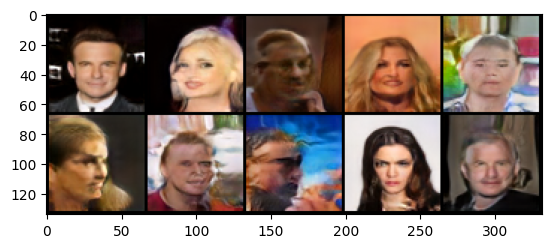

Real Images


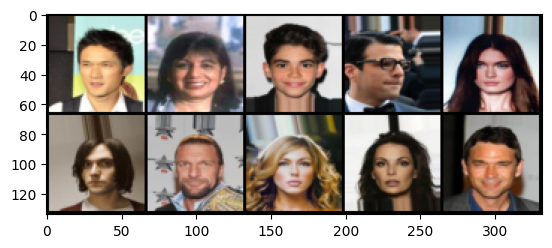

 20%|█▉        | 1000/5087 [17:55<1:12:52,  1.07s/it, disc_loss=-1.46, gen_loss=51.7] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 1000
Generated Images


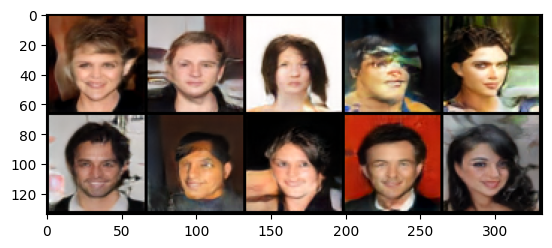

Real Images


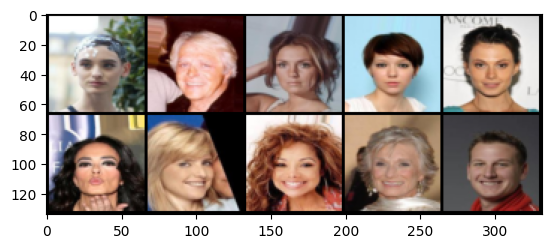

 39%|███▉      | 2000/5087 [35:47<55:01,  1.07s/it, disc_loss=-1.28, gen_loss=48]     Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 2000
Generated Images


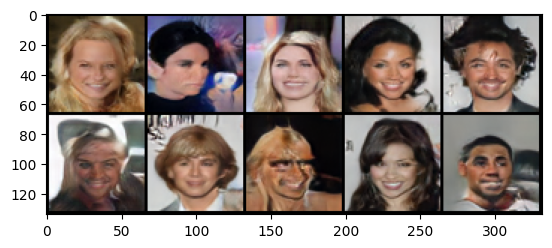

Real Images


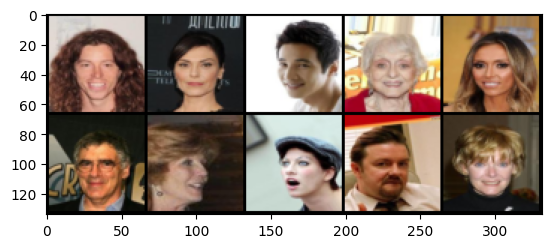

 59%|█████▉    | 3000/5087 [53:40<37:24,  1.08s/it, disc_loss=-1.08, gen_loss=47.2]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 3000
Generated Images


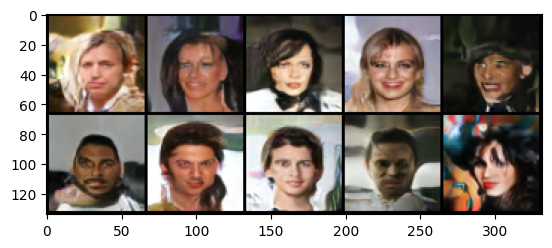

Real Images


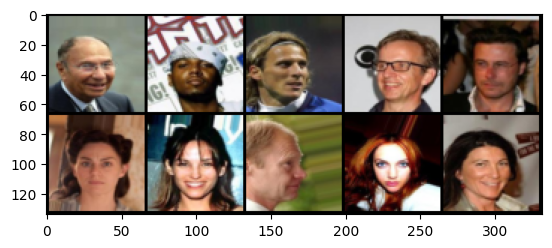

 79%|███████▊  | 4000/5087 [1:11:34<19:29,  1.08s/it, disc_loss=-1.09, gen_loss=52.7]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 4000
Generated Images


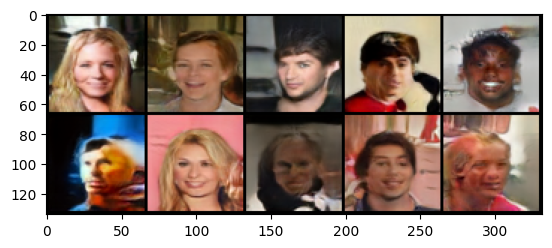

Real Images


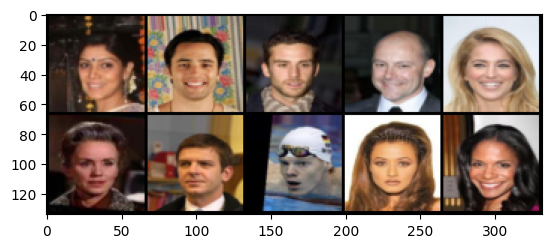

 98%|█████████▊| 5000/5087 [1:29:29<01:33,  1.08s/it, disc_loss=-1.06, gen_loss=50]    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 5000
Generated Images


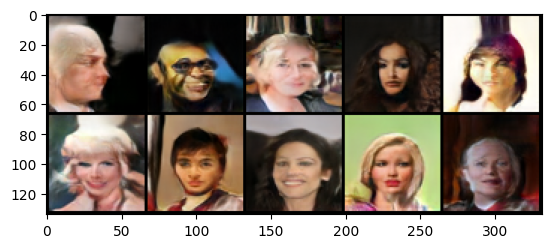

Real Images


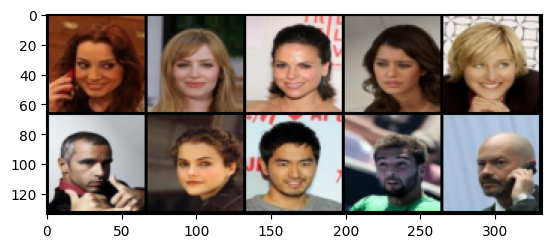

100%|██████████| 5087/5087 [1:31:03<00:00,  1.07s/it, disc_loss=-.823, gen_loss=50.2]  


Training at alpha - 0.12 complete
Generator Loss : 47.390561787159285 ------------- Discriminator Loss : -1.3628761737818142
Training for size 64x64 at alpha = 0.16


 18%|█▊        | 913/5087 [16:23<1:14:41,  1.07s/it, disc_loss=-1.05, gen_loss=45.3]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 6000
Generated Images


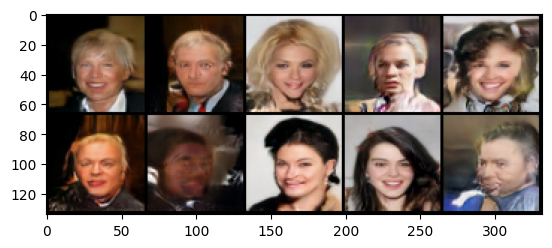

Real Images


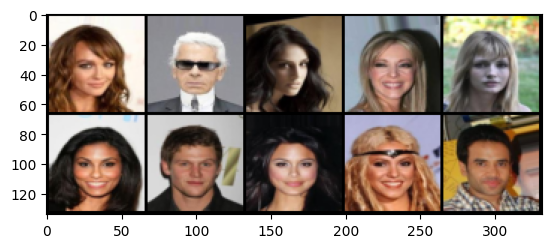

 38%|███▊      | 1913/5087 [34:16<56:37,  1.07s/it, disc_loss=-1.34, gen_loss=47.9]   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 7000
Generated Images


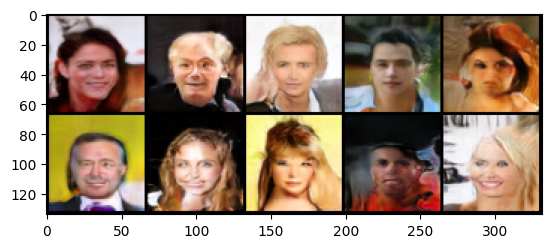

Real Images


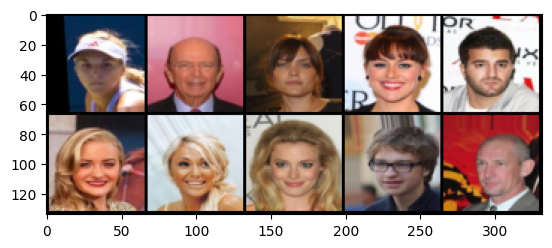

 57%|█████▋    | 2913/5087 [52:09<38:52,  1.07s/it, disc_loss=-.722, gen_loss=48.4]    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 8000
Generated Images


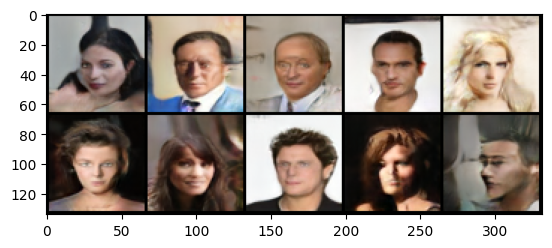

Real Images


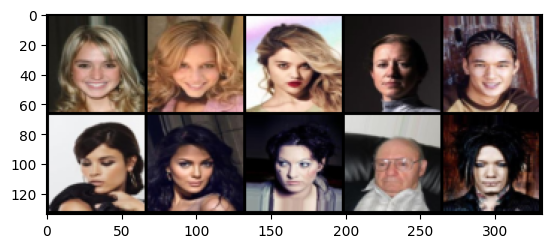

 77%|███████▋  | 3913/5087 [1:10:02<21:00,  1.07s/it, disc_loss=-.783, gen_loss=43.2] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 9000
Generated Images


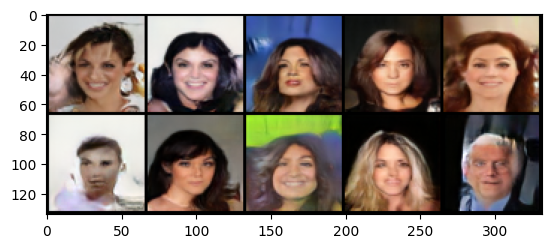

Real Images


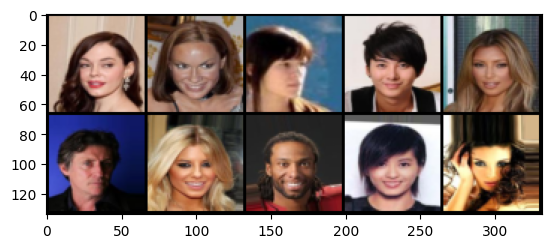

 97%|█████████▋| 4913/5087 [1:27:59<03:06,  1.07s/it, disc_loss=-1.31, gen_loss=49.9]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 10000
Generated Images


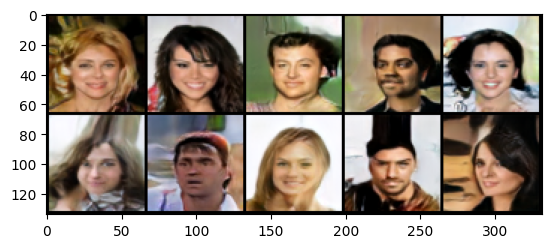

Real Images


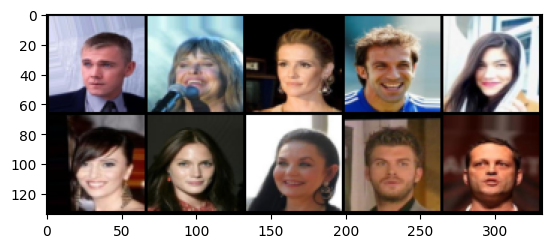

100%|██████████| 5087/5087 [1:31:06<00:00,  1.07s/it, disc_loss=-.389, gen_loss=55]    


Training at alpha - 0.16 complete
Generator Loss : 46.64664595033838 ------------- Discriminator Loss : -1.3073492697699145
Training for size 64x64 at alpha = 0.2


 16%|█▌        | 826/5087 [14:48<1:16:08,  1.07s/it, disc_loss=-.569, gen_loss=43.5] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 11000
Generated Images


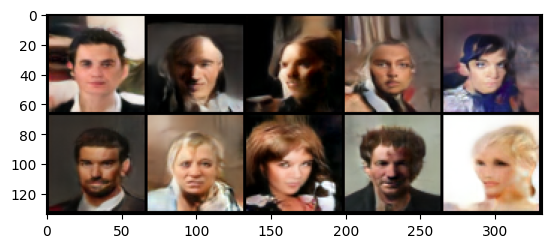

Real Images


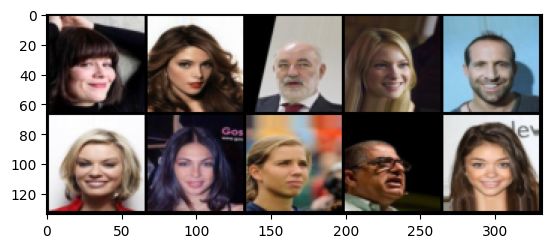

 36%|███▌      | 1826/5087 [32:40<58:20,  1.07s/it, disc_loss=-1.12, gen_loss=42.3]    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 12000
Generated Images


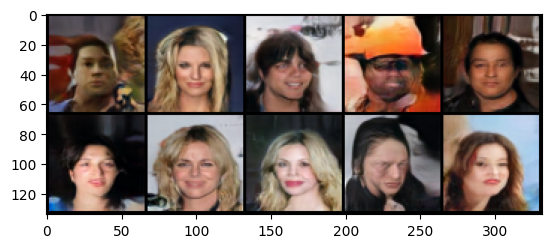

Real Images


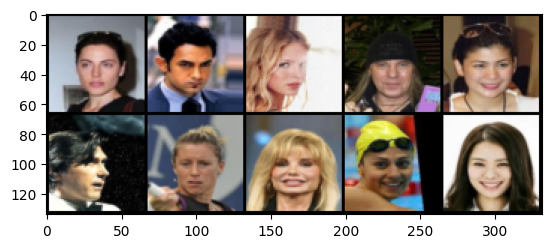

 56%|█████▌    | 2826/5087 [50:48<40:23,  1.07s/it, disc_loss=-.317, gen_loss=50.1]  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 13000
Generated Images


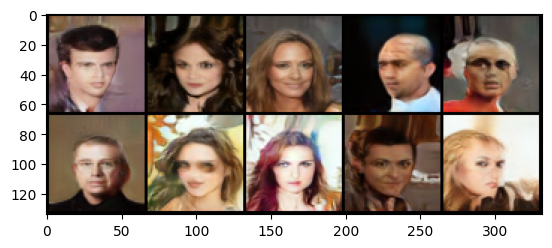

Real Images


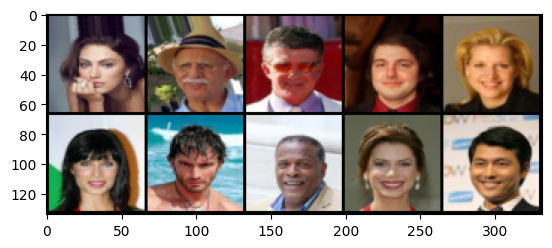

 75%|███████▌  | 3826/5087 [1:08:43<22:33,  1.07s/it, disc_loss=-1.19, gen_loss=50.4] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 14000
Generated Images


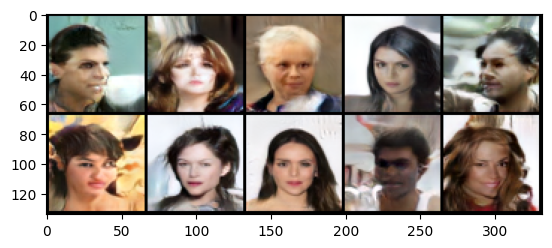

Real Images


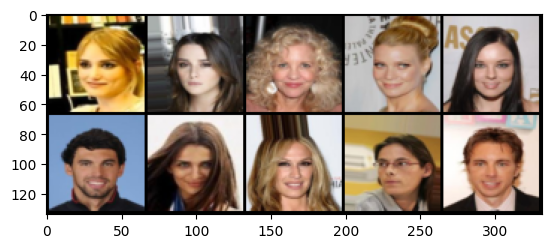

 95%|█████████▍| 4826/5087 [1:26:38<04:40,  1.07s/it, disc_loss=-.84, gen_loss=49.4]   Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying at step : 15000
Generated Images


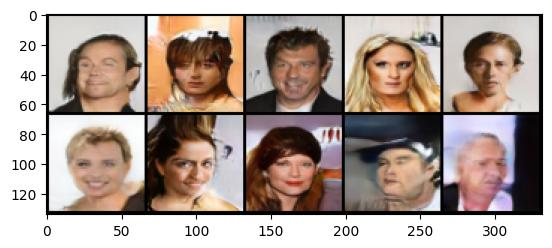

Real Images


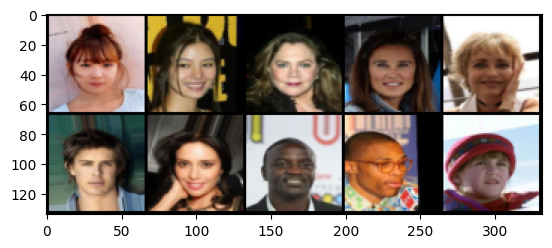

100%|██████████| 5087/5087 [1:31:19<00:00,  1.08s/it, disc_loss=-.49, gen_loss=40.6]  


Training at alpha - 0.2 complete
Generator Loss : 46.458447014861335 ------------- Discriminator Loss : -1.270611924442428
Stopping Training at size 64x64 at alpha = 0.2


In [20]:
z_dim = 256
dl = celeb_dl
display_num = 10
display_every = 1000
adv_criterion = nn.BCEWithLogitsLoss()
k = 1
cur_step = 0
blocks_to_open = 6
desired_time = (4 * 60 * 60)# + (30 * 60)
block_details = {b:f"{2**(b+2)}x{2**(b+2)}" for b in range(blocks_to_open+1)}
factors = [
    10,
    20,
    20,
    20,
    25,
    50,
    200
]
starting_size = 8
extra_steps = 10
start_time = time.time()
end_loops = False
last_run_alpha = 0.12
# steps_opened = 2
extra = False
for b in range(steps_opened, blocks_to_open):
    factor = 1 / factors[b]
    # alpha_image_range = torch.zeros(100, 3, starting_size, starting_size)
    for i, alpha in enumerate(np.arange(last_run_alpha, 1+factor, factor)):
        j = 0
        alpha = np.round(alpha, 4)
        # starting_alpha = alpha
        gen.alpha = alpha
        batch_count = 0
        gen_losses = 0
        disc_losses = 0
        print(f"Training for size {block_details[b]} at alpha = {alpha}")
        loop = tqdm(dl, leave=True)
        for img, _ in loop:
            batch_size = img.size(0)

            gen.train()
            # Discriminator Update
            disc_opt.zero_grad()

            noise = torch.randn(batch_size, z_dim).float().to(device)
            fake_imgs = gen(noise).detach()
            real_imgs = img_resize(img, fake_imgs.size(2)).float().to(device)
            fake_preds = disc(fake_imgs, alpha)
            real_preds = disc(real_imgs, alpha)
            
            #Uncommen/comment to train with BCE Loss
            # ones = torch.ones_like(real_preds)
            # zeroes = torch.zeros_like(fake_preds)
            # loss_fake = adv_criterion(fake_preds, zeroes)
            # loss_real = adv_criterion(real_preds, ones)
            # disc_loss = (loss_fake + loss_real) / 2
            #Uncomment/comment to train with W-Loss
            epsilon = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(disc, real_imgs, fake_imgs, epsilon, alpha)
            gp = gradient_penalty(gradient=gradient)
            disc_loss = get_disc_loss(real_preds, fake_preds, gp, 10)
            disc_loss.backward()
            disc_opt.step()
            disc_losses += disc_loss.item()
            
            accumulated_gen_losses = 0
            for ki in range(k):
                # Generator Update
                gen_opt.zero_grad()
                noise = torch.randn(batch_size, z_dim).float().to(device)
                fake_imgs = gen(noise)
                #Sending back the already generated images
                fake_preds = disc(fake_imgs, alpha)
                # gen_loss = adv_criterion(fake_preds, ones)
                gen_loss = get_gen_loss(fake_preds)
                gen_loss.backward()
                gen_opt.step()

                accumulated_gen_losses += gen_loss.item()
            
            gen_losses += (accumulated_gen_losses / k)

            #Check to display
            if cur_step % display_every == 0:
                gen.eval()
                print(f"Displaying at step : {cur_step}")
                print("Generated Images")
                noise = torch.randn(display_num, z_dim).float().to(device)
                fake_imgs = gen(noise).detach().cpu()
                show_images(fake_imgs)

                print("Real Images")
                reals_to_show = img[:display_num,:,:,:]
                real_imgs = img_resize(reals_to_show, fake_imgs.size(2))
                show_images(real_imgs)
            batch_count += 1
            cur_step += 1
            
            loop.set_postfix(
                gen_loss=gen_loss.item(),
                disc_loss=disc_loss.item()
            )
            
            
        #End of all batches
        print(f"Training at alpha - {alpha} complete")
        gen_loss_for_epoch = gen_losses / batch_count
        disc_loss_for_epoch = disc_losses / batch_count
        print(f"Generator Loss : {gen_loss_for_epoch} ------------- Discriminator Loss : {disc_loss_for_epoch}")

        noise = torch.randn(1, z_dim).float().to(device)
        fake_img = gen(noise).detach().cpu()
        
        #Check if 5 hours have passed
        if time.time() - start_time >= desired_time:
            print(f"Stopping Training at size {block_details[b]} at alpha = {alpha}")
            torch.save(gen.state_dict(), f"./model_checkpoints/style_gen{block_details[b]}.pth")
            torch.save(disc.state_dict(), f"./model_checkpoints/style_disc{block_details[b]}.pth")
            torch.save(gen_opt.state_dict(), f"./model_checkpoints/style_gen_opt.pth")
            torch.save(disc_opt.state_dict(), f"./model_checkpoints/style_disc_opt.pth")
            end_loops = True
            with open("./model_checkpoints/checkpoints.txt", "a") as cp:
                cp.write(f"Last trained at size {block_details[b]} at alpha : {alpha}. \n")
            break
            
    #End of all alphas
    if end_loops:
        break
    if extra:
        for j in range(extra_steps):
            batch_count = 0
            gen_losses = 0
            disc_losses = 0
            print(f"Training for size {block_details[b]} at alpha = {alpha}")
            for img, _ in tqdm(dl):
                batch_size = img.size(0)
                # Discriminator Update
                disc_opt.zero_grad()

                noise = torch.randn(batch_size, z_dim).float().to(device)
                fake_imgs = gen(noise).detach()
                real_imgs = img_resize(img, fake_imgs.size(2))
                fake_preds = disc(fake_imgs, alpha)
                real_preds = disc(real_imgs.to(device), alpha)

                #Uncommen/comment to train with BCE Loss
    #             ones = torch.ones_like(real_preds)
    #             zeroes = torch.zeros_like(fake_preds)
    #             loss_fake = adv_criterion(fake_preds, zeroes)
    #             loss_real = adv_criterion(real_preds, ones)
    #             disc_loss = (loss_fake + loss_real) / 2
                #Uncomment/comment to train with W-Loss
                epsilon = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
                gradient = get_gradient(disc, real_imgs.float().to(device), fake_imgs, epsilon, alpha)
                gp = gradient_penalty(gradient=gradient)
                disc_loss = get_disc_loss(real_preds, fake_preds, gp, 10)
                disc_loss.backward()
                disc_opt.step()
                disc_losses += disc_loss.item()


                # Generator Update
                gen_opt.zero_grad()
                noise = torch.randn(batch_size, z_dim).float().to(device)
                fake_imgs = gen(noise)
                fake_preds = disc(fake_imgs, alpha)
                # gen_loss = adv_criterion(fake_preds, ones)
                gen_loss = get_gen_loss(fake_preds)
                gen_loss.backward()
                gen_opt.step()

                gen_losses += gen_loss.item()

                #Check to display
                if cur_step % display_every == 0:

                    print(f"Displaying at step : {cur_step}")
                    print("Generated Images")
                    noise = torch.randn(display_num, z_dim).float().to(device)
                    fake_imgs = gen(noise).detach().cpu()
                    show_images(fake_imgs)

                    print("Real Images")
                    reals_to_show = img[:display_num,:,:,:]
                    real_imgs = img_resize(reals_to_show, fake_imgs.size(2))
                    show_images(real_imgs)
                batch_count += 1
                cur_step += 1
            #End of all batches

            if time.time() - start_time >= desired_time:
                print(f"Stopping Training at size {block_details[b]} at alpha = 1 extra rounds")
                torch.save(gen.state_dict(), f"./model_checkpoints/style_gen{block_details[b]}.pth")
                torch.save(disc.state_dict(), f"./model_checkpoints/style_disc{block_details[b]}.pth")
                torch.save(gen_opt.state_dict(), f"./model_checkpoints/style_gen_opt.pth")
                torch.save(disc_opt.state_dict(), f"./model_checkpoints/style_disc_opt.pth")
                end_loops = True
                with open("./model_checkpoints/checkpoints.txt", "a") as cp:
                    cp.write(f"Last trained at size {block_details[b]} at alpha : 1 extra rounds. \n")
                break


            print(f"Training at alpha - {alpha} round {j} complete")
            gen_loss_for_epoch = gen_losses / batch_count
            disc_loss_for_epoch = disc_losses / batch_count
            print(f"Generator Loss : {gen_loss_for_epoch} ------------- Discriminator Loss : {disc_loss_for_epoch}")
        if end_loops:
            break
    print(
    f"""
    --------------------------------------------------------------------
    Finished Training at size : {block_details[b]}
    --------------------------------------------------------------------
    """)
    
    
    torch.save(gen.state_dict(), f"./model_checkpoints/saved_models/style_gen{block_details[b]}_end.pth")
    torch.save(disc.state_dict(), f"./model_checkpoints/saved_models/style_disc{block_details[b]}_end.pth")
    torch.save(gen_opt.state_dict(), f"./model_checkpoints/saved_optimizers/style_gen_opt_{block_details[b]}_end.pth")
    torch.save(disc_opt.state_dict(), f"./model_checkpoints/saved_optimizers/style_disc_opt_{block_details[b]}_end.pth")
    
    #Reinitialize dataloader with new size
    starting_size *= 2
    
    gen.update_opened_blocks()
    disc.update_opened_blocks()
    last_run_alpha = 0
#All blocks trained

In [25]:
torch.save(gen.state_dict(), "./model_checkpoints/style_gen32x32.pth")
torch.save(disc.state_dict(), "./model_checkpoints/style_disc32x32.pth")

In [26]:
torch.save(gen_opt.state_dict(), f"./model_checkpoints/style_gen_opt.pth")
torch.save(disc_opt.state_dict(), f"./model_checkpoints/style_disc_opt.pth")